## P-set 1.

# Problem 1
## Question
>1) 50 points 
>
>What are the eigenvalues and eigenvectors of the Pauli-Y matrix? (Analytical)
>

## Solution

The Pauli-Y matrix is given by
$$
\sigma_{y}\equiv Y = 
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\,,
$$
which describes a rotation by $\pi\; \mathrm{rads}$ about the $y$-axis of the Bloch sphere. The eigenvalues of all Pauli-matrices (by virtue of their definitions as rotations about the $x,y,\text{ and } z$ axes) are $\pm1$, with their vectors corresponding to the positive and negative of the axis. 

The eigenvectors of any matrix $M$ can be found by computing
$$
M\ket{\psi}=\lambda \ket{\psi}, \quad \ket{\psi} \in \mathcal{H}, ~\lambda \in \mathbb{C}\,,
$$
$$
\therefore \det\left( M - \lambda \mathbb{I} \right) = 0\,.
$$
Computing this for $\sigma_{Y}$:
$$
\det 
\begin{pmatrix}
-\lambda & -i \\
i & -\lambda
\end{pmatrix}
=\lambda^{2}-1\stackrel{\text{set}}{=}0\,,
$$
$$
\therefore \lambda_{1,2}=\pm 1\,.
$$
Finding the eigenvectors now is done by calculating
$$
\left({ M-\lambda_{1,2}\; \mathbb{I} }\right)\ket{\psi}  = \vec{0}\,. 
$$

So the eigenvectors for $\sigma_{Y}$ are:
$$
= \begin{bmatrix}
\mp 1 & -i \\
i & \mp 1
\end{bmatrix}
\begin{bmatrix}
\psi_{1} \\
\psi_{2}
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}\,,
$$
$$
\implies \mp \psi_{1} -i\psi_{2} = 0 = i\psi_{1} \mp \psi_{2}\,,
$$
$$
-\left( \pm 1 + i \right)\psi_{1} + \left( \pm1 - i \right)\psi_{2}=0\,,
$$
$$
\psi_{2}= \frac{\pm 1 + i}{\pm 1 - i}\psi_{1}\,.
$$

This can be simplified to give us:
$$
\begin{align*}
\psi_{2}=&\frac{\pm 1 + i}{\pm 1 - i} \cdot  \frac{\pm 1 + i}{\pm 1 + i} \cdot \psi_{1} \\
 \\
& \frac{1 \pm 2i - 1}{1+1}\psi_{1} \\
 \\
\therefore \psi_{2}=& \pm i \psi_{1}\,.
\end{align*}
$$

After normalizing, our eigenvectors are
$$
\frac{1}{\sqrt{ 2 }}\left( \ket{0} \pm i\ket{1}  \right) \equiv \ket{i\pm}\,.
$$

# Problem 2
## Question
>2) 20 points
>
>Plot the eigenvectors on the Bloch Sphere. (Use Qiskit)

## Solution
This code will combine the eigenvectors into a composite state and then plot them with **qubit 0** being the first eigenvector $\ket{i-}$ and **qubit 1** being the second $\ket{i+}$.

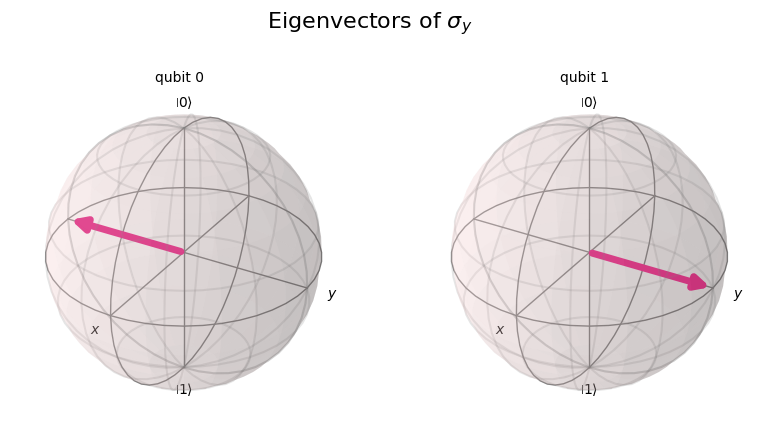

In [1]:
from numpy import kron
from numpy.linalg import eig
from qiskit.quantum_info import Pauli, Statevector
from qiskit.visualization import plot_bloch_multivector

eig_vecs = eig(Pauli('Y'))[1]
composite_state = Statevector(kron(*[vec for vec in eig_vecs])) 
plot_bloch_multivector(composite_state,title="Eigenvectors of $\\sigma_{y}$")

# Problem 3
## Question
>3) 30 points 
>
>Propose a suitable Ansatz (parameterized quantum circuit) to find the minimum eigenvalue of the Pauli-Y matrix with the VQE routine.

## Solution
Our VQE expression is:
$$
\mathrm{min}\left( \bra{\psi(\theta)}\hat{Y}\ket{\psi{\theta}} \right)\,.
$$

Now, an appropriate Ansatz for this would be the X-rotation matrix:
$$
\text{Ansatz} = \ket{\psi(\theta)} = R_{x}(\theta)\ket{0} = 
\begin{bmatrix}
\cos \frac{\theta}{2}&  -i\sin \frac{\theta}{2}\\
-i\sin \frac{\theta}{2}&    \cos \frac{\theta}{2}
\end{bmatrix}
\begin{bmatrix}
1\\0
\end{bmatrix}\,,
$$
so,
$$
\ket{\psi(\theta)} = \cos\frac{\theta}{2}\ket{0} - i\sin\frac{\theta}{2}\ket{1}\,.
$$

We shall now implement this with a parameterized quantum circuit.

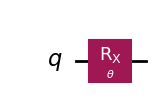

In [2]:
# General imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Optimization function
from scipy.optimize import minimize

#Visualization
import matplotlib.pyplot as plt

# Qiskit Estimator primitive
from qiskit_ibm_runtime import EstimatorV2 as Estimator



###Creating the Ansatz

func = SparsePauliOp('Y') # This is what we are calculating the minimum eigenvalue of

theta = Parameter('$\\theta$') # You can use Latex if you plot using `style="iqp"`
ansatz = QuantumCircuit(1)
ansatz.rx(theta,0)

ansatz.draw("mpl",style="iqp") # The iqp allows for Latex


In [4]:
# Loading your IBM Quantum account
with open("../../api_key.txt", 'r') as file:
    token = file.read()

from qiskit_ibm_runtime import QiskitRuntimeService, Session

service = QiskitRuntimeService(channel="ibm_quantum",token=token)
real_backend = service.least_busy(operational=True, simulator=False)
print(f"Connected to: {real_backend}")


Connected to: <IBMBackend('ibm_brisbane')>


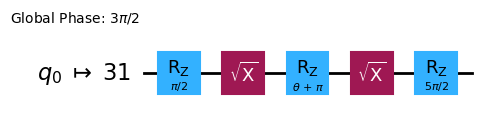

In [5]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

fake_backend = AerSimulator.from_backend(real_backend) # Running on a quantum computer takes forever so just simulate it for a job this small

target = fake_backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3) # This transpiles the circuit for efficient execution on selected Qcomputer

ansatz_isa = pm.run(ansatz) # Apply optimisation to ansatz
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [6]:
func_isa = func.apply_layout(layout=ansatz_isa.layout) # Apply an optimization to the function

In [7]:
def cost_func(params, ansatz, func, estimator):
    global cost_history_dict
    
    pub = (ansatz, [func], [params])
    result = estimator.run(pubs=[pub]).result()
    eigenvalue = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(eigenvalue)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {eigenvalue}]")

    return eigenvalue

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters) # Random first guess

In [8]:
# Now to run the VQE algorithm
with Session(backend=fake_backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, func_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.054]
Iters. done: 2 [Current cost: 0.8614]
Iters. done: 3 [Current cost: -0.7918]
Iters. done: 4 [Current cost: -0.9236]
Iters. done: 5 [Current cost: -0.1964]
Iters. done: 6 [Current cost: -0.6182]
Iters. done: 7 [Current cost: -0.9822]
Iters. done: 8 [Current cost: -0.9812]
Iters. done: 9 [Current cost: -0.9886]
Iters. done: 10 [Current cost: -0.9788]
Iters. done: 11 [Current cost: -0.9844]
Iters. done: 12 [Current cost: -0.9876]
Iters. done: 13 [Current cost: -0.986]
Iters. done: 14 [Current cost: -0.9894]
Iters. done: 15 [Current cost: -0.9878]
Iters. done: 16 [Current cost: -0.988]
Iters. done: 17 [Current cost: -0.9884]
Iters. done: 18 [Current cost: -0.9872]
Iters. done: 19 [Current cost: -0.9872]
Iters. done: 20 [Current cost: -0.9868]
Iters. done: 21 [Current cost: -0.9862]
Iters. done: 22 [Current cost: -0.9874]


In [9]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9874
       x: [ 1.566e+00]
    nfev: 22
   maxcv: 0.0

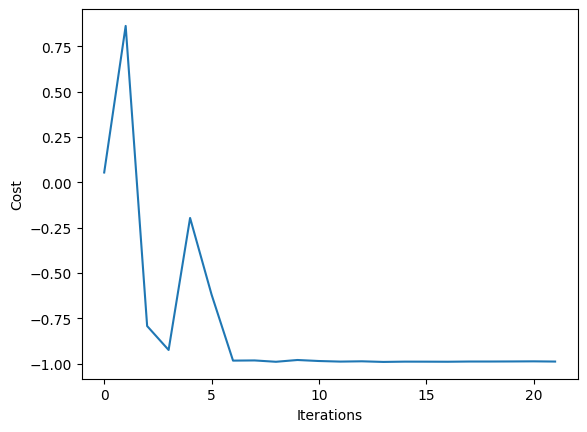

In [10]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

This shows that the result converged to -1: the minimum eigenvalue. However, this approach is super slow compared to just normal computation. With larger matrices (and smart choices of ansatz, cost function, and minimization algorithm), however, there is promise that the quantum approach could outcompete classical computation. 

In [11]:
np.round(min(np.linalg.eigvals(func)), 2) # Classical computation for this problem takes less than a tenth of a second.

(-1+0j)